In [2]:
import torch
import numpy

In [3]:
def Dinvmatrix_torch(N):
    """produces a causal inverse delay matrix D^{-1}(z), which has 
    delays z^-1  on the lower half in 3D polynomial representation (exponents of z^-1 are in third dimension)
    N is the number of subbands and size of the polynomial matrix (NxN)
    N is even"""
    D = torch.zeros((N,N,2))
    D[:,:,0] = torch.diag((torch.cat((torch.ones((int(N/2))),torch.zeros((int(N/2)))))))
    D[:,:,1] = torch.diag((torch.cat((torch.zeros((int(N/2))),torch.ones((int(N/2)))))))
    return D

In [4]:
def Dmatrix_torch(N):
    """produces a delay matrix D(z), which has delay z^-1 on the upper half of its diagonal
    in a 3D polynomial representation (exponents of z^-1 are in the third dimension) 
    N is number of subbands and size of the polynomial matrix (NxN) 
    N is even""" 
    D=torch.zeros((N,N,2))
    D[:,:,0] = torch.diag(torch.cat((torch.zeros((int(N/2))), torch.ones((int(N/2))))))
    D[:,:,1] = torch.diag(torch.cat((torch.ones((int(N/2))), torch.zeros((int(N/2))))))
    return D

In [5]:
def symFmatrix_torch(f):
    """produces a diamond shaped folding matrix F from the coefficients f
    (f is a 1-d array)
    which leads to identical analysis and synthesis baseband impulse responses
    Hence has det 1 or -1
    If N is number of subbands, then f is a vector of size 1.5*N coefficients.
    N is even
    returns: F of shape (N,N,1)
    """   
    sym=1.0; #The kind of symmetry: +-1
    N = int(len(f)/1.5);
    F=torch.zeros((N,N,1))
    F[0:int(N/2),0:int(N/2),0]=torch.fliplr(torch.diag(f[0:int(N/2)]))
    F[int(N/2):N,0:int(N/2),0]=torch.diag(f[int(N/2):N])
    F[0:int(N/2),int(N/2):N,0]=torch.diag(f[N:(N+int(N/2))])
    f_rev = torch.flipud(f)
    ff = torch.flipud((sym*torch.ones((int(N/2))) - (f[N:(int(1.5*N))])*f_rev[int(N/2):N])/f[0:int(N/2)])    
    F[int(N/2):N,int(N/2):N,0]=-torch.fliplr(torch.diag(ff))
    return F

In [6]:
def polmatmult_torch( A,B ):
   """polmatmult(A,B)
   multiplies two polynomial matrices (arrays) A and B, where each matrix entry is a polynomial.
   Those polynomial entries are in the 3rd dimension
   The thirs dimension can also be interpreted as containing the (2D) coefficient
   exponent of z^-1.
   Result is C=A*B;"""  
   [NAx, NAy, NAz] = A.shape;
   [NBx, NBy, NBz] = B.shape;
   #Degree +1 of resulting polynomial, with NAz-1 and NBz-1 being the degree of the...
   Deg = NAz + NBz -1;
   C = torch.zeros((NAx,NBy,Deg));
   #Convolution of matrices:
   for n in range(0,(Deg)):
       for m in range(0,n+1):
           if ((n-m)<NAz and m<NBz):
               C[:,:,n] = C[:,:,n]+ np.matmul(A[:,:,(n-m)],B[:,:,m]);
   return C

In [7]:
def polyphase2x_torch(xp):
   """Converts polyphase input signal xp (a row vector) into a contiguos row vector
   For block length N, for 3D polyphase representation (exponents of z in the third 
   matrix/tensor dimension)"""

   x=torch.reshape(xp,(1,1,-1))
   x=x[0,0,:]
   return x

In [8]:
def reshape_fortran(x, shape):
    if len(x.shape) > 0:
        x = x.permute(*reversed(range(len(x.shape))))
    return x.reshape(*reversed(shape)).permute(*reversed(range(len(shape))))

In [16]:
def x2polyphase_torch(x,N):
    """Converts input signal x (a 1D array) into a polyphase row vector 
    xp for blocks of length N, with shape: (1,N,#of blocks)"""     
    #Convert stream x into a 2d array where each row is a block:
    #xp.shape : (y,x, #num blocks):
    x=x[:int(len(x)/N)*N] #limit signal to integer multiples of N
    #xp=torch.reshape(x,(N,-1)) #order=F: first index changes fastest
    xp = reshape_fortran(x, (N,-1))
    #add 0'th dimension for function polmatmult:
    xp=torch.unsqueeze(xp, dim=0)
    return xp

In [17]:
from scipy.fft import dct, idct
from torch.autograd import Function


class DCT3Function(Function):
    @staticmethod
    def forward(ctx, input):
        scipy_input = input.detach().numpy()
        result = dct(scipy_input, type=3,axis=1,norm='ortho')
        return input.new(result)

    @staticmethod
    def backward(ctx, grad_output):
        numpy_go = grad_output.numpy()
        result = idct(numpy_go, type=3,axis=1,norm='ortho')
        return grad_output.new(result)

In [18]:
def dct3_torch(input):
    return DCT3Function.apply(input)

In [19]:
#The DCT4 transform:
def DCT4_torch(samples):
   #Argument: 3-D array of samples, shape (y,x,# of blocks), each row correspond to 1 row 
   #to apply the DCT to.
   #Output: 3-D array where each row ist DCT4 transformed, orthonormal.
   #use a DCT3 to implement a DCT4:
   r,N,blocks=samples.shape
   samplesup=torch.zeros((1,2*N,blocks))
   #upsample signal:
   samplesup[0,1::2,:]=samples
   y=dct3_torch(samplesup)*torch.sqrt(torch.tensor(2))
   return y[:,0:N,:]

In [20]:
def MDCTanafb_torch(x,N,fb):
   #MDCT analysis filter bank.
   #Arguments: x: input signal, e.g. audio signal, a 1-dim. array
   #N: number of subbands
   #fb: coefficients for the MDCT filter bank, for the F matrix, np.array with 1.5*N coefficients.
   #returns y, consisting of blocks of subband in in a 2-d array of shape (N,# of blocks)
   
   Fa=symFmatrix_torch(fb)
   D=Dmatrix_torch(N)
   y=x2polyphase_torch(x,N)
   y=polmatmult_torch(y,Fa)   
   y=polmatmult_torch(y,D)
   y=DCT4_torch(y)
   #strip first dimension:
   y=y[0,:,:]
   return y

fb= tensor([0.1951, 0.5556, 0.8315, 0.9808, 0.9808, 0.8315], dtype=torch.float64)


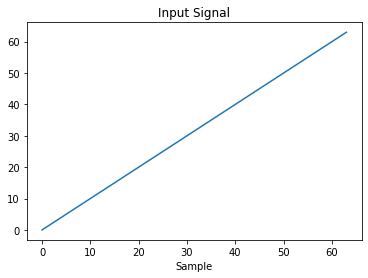

y=
 tensor([[-2.6850e-01,  4.3869e+00,  1.2387e+01,  2.0387e+01,  2.8387e+01,
          3.6387e+01,  4.4387e+01,  5.2387e+01,  6.0387e+01,  6.8387e+01,
          7.6387e+01,  8.4387e+01,  9.2387e+01,  1.0039e+02,  1.0839e+02,
          1.1639e+02,  1.0247e+02],
        [ 5.1577e-01, -1.1989e+00, -1.1989e+00, -1.1989e+00, -1.1989e+00,
         -1.1989e+00, -1.1989e+00, -1.1989e+00, -1.1989e+00, -1.1989e+00,
         -1.1989e+00, -1.1989e+00, -1.1989e+00, -1.1989e+00, -1.1989e+00,
         -1.1989e+00,  4.0095e+01],
        [-2.4517e-01, -3.3182e-01, -3.3182e-01, -3.3182e-01, -3.3182e-01,
         -3.3182e-01, -3.3182e-01, -3.3182e-01, -3.3182e-01, -3.3182e-01,
         -3.3183e-01, -3.3182e-01, -3.3183e-01, -3.3183e-01, -3.3182e-01,
         -3.3182e-01, -1.7405e+01],
        [-1.5015e-01,  8.2393e-02,  8.2392e-02,  8.2391e-02,  8.2392e-02,
          8.2395e-02,  8.2393e-02,  8.2392e-02,  8.2389e-02,  8.2389e-02,
          8.2395e-02,  8.2389e-02,  8.2395e-02,  8.2389e-02,  8.2395e-02,


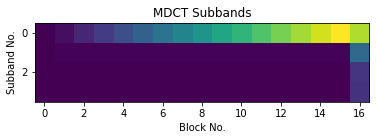

In [21]:
import matplotlib.pyplot as plt
#Number of subbands:
N=4
D=Dmatrix_torch(N)
Dinv=Dinvmatrix_torch(N)
#Filter bank coefficients for sine window:
fb=torch.from_numpy(np.sin(np.pi/(2*N)*(np.arange(int(1.5*N))+0.5)))
print("fb=", fb)
#input test signal, ramp:
x=torch.from_numpy(np.arange(64))
plt.plot(x.numpy())
plt.title('Input Signal')
plt.xlabel('Sample')
plt.show()
y=MDCTanafb_torch(x,N,fb); print("y=\n", y)
plt.imshow(np.abs(y.numpy()))
plt.title('MDCT Subbands')
plt.xlabel('Block No.')
plt.ylabel('Subband No.')
plt.show()

In [22]:
def MDCTsynfb_torch(y,fb):
   #MDCT synthesis filter bank.
   #Arguments: y: 2-d array of blocks of subbands, of shape (N, # of blokcs)
   #returns xr, the reconstructed signal, a 1-d array.   
   
   N=y.shape[0]
   Fa=symFmatrix_torch(fb)
   #invert Fa matrix for synthesis after removing last dim:
   Fs=torch.linalg.inv(Fa[:,:,0])
   #add again last dimension for function polmatmult:
   Fs=torch.torch.unsqueeze(Fs, dim=1)
   Dinv=Dinvmatrix_torch(N)

   #add first dimension to y for polmatmult:
   y=torch.unsqueeze(y,dim=0)
   xp=DCT4_torch(y)
   xp=polmatmult_torch(xp,Dinv)
   xp=polmatmult_torch(xp,Fs)
   xr=polyphase2x_torch(xp)
   return xr

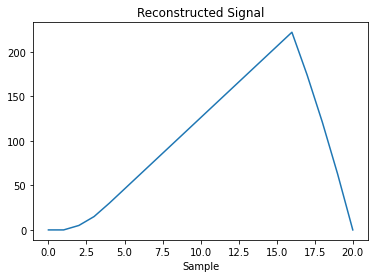

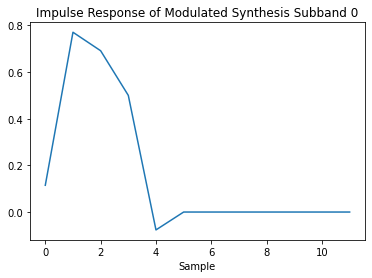

In [ ]:
xr=MDCTsynfb_torch(y,fb)
plt.plot(xr.numpy())
plt.title('Reconstructed Signal')
plt.xlabel('Sample')
plt.show()
y=torch.zeros((4,16))
y[0,0]=1
xr=MDCTsynfb_torch(y,fb)
plt.plot(xr[0:3*N].numpy())
plt.title('Impulse Response of Modulated Synthesis Subband 0')
plt.xlabel('Sample')
plt.show()